In [1]:
from os.path import join
from matplotlib import pyplot as plt
import numpy as np
import mne
from sklearn.preprocessing import Normalizer, StandardScaler
from mne.viz import plot_alignment, set_3d_title
from util import load_subjects_list
from const import BASE_WORKDIR

In [2]:
def add_sensor_coord(index, power, evoked):
    # subset case: re-scale magnetic field power to same(close) magnitute as coordinates 
    return list(np.append(evoked.info['chs'][index]['loc'][:3].copy(), power * 10e+15))

def to_features_array(evoked):
    features = np.array([[add_sensor_coord(index, power, evoked) for index, power in enumerate(observed_timestamp)] for observed_timestamp in evoked.data.T])
    return features.reshape(features.shape[0], -1)

def norm(feature_matrix):
    transformer = StandardScaler().fit(feature_matrix)
    return transformer.transform(feature_matrix)

ITERATIONS = 10
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
full_data = []
full_dipoles = []
subset_data = []
subset_dipoles = []

T_MIN = 0
T_MAX = None

for subject in load_subjects_list():
    # collect subject for full-case
    fe = mne.read_evokeds(f"{BASE_WORKDIR}/{subject}/evoked-full-ave.fif", verbose="ERROR")[0].crop(T_MIN, T_MAX)
    fd = mne.read_dipole(f'{BASE_WORKDIR}/{subject}/full-dipoles.dip', verbose="ERROR").crop(T_MIN, T_MAX)
    full_data.append(fe.data.T)
    full_dipoles.append(fd.pos)
    for i in range(ITERATIONS):
        # collect subject for subset-case
        se = mne.read_evokeds(f"{BASE_WORKDIR}/{subject}/random-{i}-ave.fif", verbose="ERROR")[0].crop(0, 0.1)
        sd = mne.read_dipole(f'{BASE_WORKDIR}/{subject}/random-{i}-dipoles.dip', verbose="ERROR").crop(0, 0.1)
        subset_data.append(to_features_array(se))
        subset_dipoles.append(sd.pos)

full_data = np.concatenate(full_data, axis=0)
full_dipoles = np.concatenate(full_dipoles, axis=0)
subset_data = np.concatenate(subset_data, axis=0)
subset_dipoles = np.concatenate(subset_dipoles, axis=0)

print('Case full features:', full_data.shape)
print('Case full labels', full_dipoles.shape)
print('Case subset features', subset_data.shape)
print('Case subset labels', subset_dipoles.shape)

Case full features: (8407, 273)
Case full labels (8407, 3)
Case subset features (8470, 40)
Case subset labels (8470, 3)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
import timeit

def rmse(ground_truth, predictions):
    # Calculate Root Mean Squared Error (RMSE) for the distances
    distances = np.sqrt(np.sum((ground_truth - predictions)**2, axis=1))
    return np.sqrt(mean_squared_error(np.zeros_like(distances), distances))

def displacement_error(ground_truth, predictions):
    # Calculate mean displacement error
    displacement = np.linalg.norm(predictions - ground_truth, axis=1)
    return np.mean(displacement)

def neg_displacement(x, y):
    return -displacement_error((x),(y))

def measure_speed(estimator, features):
    return timeit.timeit('estimator.predict(features)', globals=locals(), number=1)

def test_model(model, param_grid, features, labels):
    X_train, X_test, y_train, y_test = train_test_split(norm(features), labels, test_size=0.2, random_state=RANDOM_STATE)
    grid_search = GridSearchCV(
        MultiOutputRegressor(model), 
        param_grid, 
        cv=5, 
        scoring=make_scorer(neg_displacement),
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    best_estimator = grid_search.best_estimator_
    predictions = best_estimator.predict(X_test)
    print('unique predicted points:', len(np.unique(predictions, axis=0)))
    return {
        'estimator': best_estimator,
        'rmse': rmse(y_test, predictions),
        'displacement': displacement_error(y_test, predictions),
        'y_test': y_test,
        'predictions': predictions
    }

In [8]:
results = dict()

In [32]:
from sklearn.svm import SVR
param_grid = {
    'estimator__C': [1],
    'estimator__kernel': ['rbf'],
    'estimator__gamma': [1],
    'estimator__epsilon': [0.0001] 
}
results['svr_full'] = test_model(SVR(), param_grid, full_data, full_dipoles)
results['svr_subset'] = test_model(SVR(), param_grid, subset_data, subset_dipoles)

Best Parameters: {'estimator__C': 1, 'estimator__epsilon': 0.0001, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}
unique predicted points: 1682
Best Parameters: {'estimator__C': 1, 'estimator__epsilon': 0.0001, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}
unique predicted points: 1694


In [33]:
print(results['svr_full']['displacement'])
print(results['svr_subset']['displacement'])

0.010350801478965358
0.01121210279709984


In [35]:
from sklearn.svm import NuSVR
param_grid = {
    'estimator__C': [1.0],
    'estimator__kernel': ['rbf'],
    'estimator__degree': [3, 4],
    'estimator__gamma': [0.001, 1, 'scale'],
    'estimator__coef0': [0.0, 0.3],
    'estimator__shrinking': [True, False], 
    'estimator__cache_size': [500]
}
results['nusvr_full'] = test_model(NuSVR(), param_grid, full_data, full_dipoles)
results['nusvr_subset'] = test_model(NuSVR(), param_grid, subset_data, subset_dipoles)

Best Parameters: {'estimator__C': 1.0, 'estimator__cache_size': 500, 'estimator__coef0': 0.0, 'estimator__degree': 3, 'estimator__gamma': 1, 'estimator__kernel': 'rbf', 'estimator__shrinking': True}
unique predicted points: 1682
Best Parameters: {'estimator__C': 1.0, 'estimator__cache_size': 500, 'estimator__coef0': 0.0, 'estimator__degree': 3, 'estimator__gamma': 1, 'estimator__kernel': 'rbf', 'estimator__shrinking': False}
unique predicted points: 1694


In [37]:
print(results['nusvr_full']['displacement'])
print(results['nusvr_subset']['displacement'])

0.010394766077588411
0.011283433572182216


In [15]:
from sklearn.tree import DecisionTreeRegressor
param_grid = {
    'estimator__max_depth': [None, 5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [2, 4, 10],
    'estimator__max_features': [0.1, 1, 'sqrt', 'log2']
}
results['dt_full'] = test_model(DecisionTreeRegressor(), param_grid, full_data, full_dipoles)
results['dt_subset'] = test_model(DecisionTreeRegressor(), param_grid, subset_data, subset_dipoles)

Best Parameters: {'estimator__max_depth': None, 'estimator__max_features': 0.1, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2}
unique predicted points: 1542
Best Parameters: {'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2}
unique predicted points: 1533


In [16]:
print(results['dt_full']['displacement'])
print(results['dt_subset']['displacement'])

0.009041249277392839
0.013051585122226829


In [19]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'estimator__n_estimators': [100, 200, 500],
    'estimator__max_depth': [None, 5, 10],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [2, 4],
    'estimator__max_features': [0.1, 1, 'sqrt', 'log2']
}
results['rf_full'] = test_model(RandomForestRegressor(), param_grid, full_data, full_dipoles)
results['rf_subset'] = test_model(RandomForestRegressor(), param_grid, subset_data, subset_dipoles)

Best Parameters: {'estimator__max_depth': None, 'estimator__max_features': 0.1, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 500}
unique predicted points: 1682
Best Parameters: {'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 500}
unique predicted points: 1694


In [21]:
print(results['rf_full']['displacement'])
print(results['rf_subset']['displacement'])

0.00786050307465797
0.011185727284462748


In [ ]:
# Remove this or one of trees
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {
    #'estimator__loss': ['absolute_error', 'squared_error', 'huber', 'quantile'],
    'estimator__learning_rate': [0.1],
    'estimator__n_estimators': [200],
    'estimator__max_depth': [7],
    #'estimator__min_samples_split': [2, 5, 10],
    #'estimator__min_samples_leaf': [1, 2, 4],
    #'estimator__max_features': [0.1, 0.5, 1, 'sqrt', 'log2', None] 
}
results['gbr_full'] = test_model(GradientBoostingRegressor(), param_grid, full_data, full_dipoles)
results['gbr_subset'] = test_model(GradientBoostingRegressor(), param_grid, subset_data, subset_dipoles)

In [24]:
from xgboost.sklearn import XGBRegressor
param_grid = {
    'estimator__learning_rate': [0.1],# [0.001, 1]
    'estimator__n_estimators': [1000, 2000],#[100, 200, 300],
    'estimator__max_depth': [10, 20, 30],#[3, 5, 7],
    #'estimator__min_child_weight': [1, 3, 5],
    #'estimator__gamma': [0],
    #'estimator__subsample': [0.6, 0.8, 1.0],
    #'estimator__colsample_bytree': [0.6, 0.8, 1.0],
    #'estimator__reg_alpha': [0, 0.1, 0.5],
    #'estimator__reg_lambda': [0, 0.1, 0.5],
    'estimator__random_state': [42]
}
results['xgb_full']  = test_model(XGBRegressor(device='gpu', n_jobs=-1), param_grid, full_data, full_dipoles)
results['xgb_subset'] = test_model(XGBRegressor(device='gpu', n_jobs=-1), param_grid, subset_data, subset_dipoles)

/home/s8/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
24 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/s8/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/s8/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/s8/miniconda3/envs/p310/lib/python3.10/site-packages/sklearn/multioutput.py", line 270, in fit
    self.esti

Best Parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__n_estimators': 1000, 'estimator__random_state': 42}
unique predicted points: 1682


/home/s8/miniconda3/envs/p310/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:43:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/s8/miniconda3/envs/p310/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:43:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in

Best Parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 20, 'estimator__n_estimators': 1000, 'estimator__random_state': 42}
unique predicted points: 1691


In [25]:
print(results['xgb_full']['displacement'])
print(results['xgb_subset']['displacement'])

0.006980016778461912
0.00984926458459202


In [24]:
import pickle
with open(f"{BASE_WORKDIR}/results.pkl", 'wb') as file:
    pickle.dump(results, file)

In [25]:
import pickle
with open(f"{BASE_WORKDIR}/results.pkl", 'rb') as file:
    loaded_object = pickle.load(file)
print(loaded_object)
results = loaded_object

{'xgb_full': {'estimator': MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device='gpu',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=N

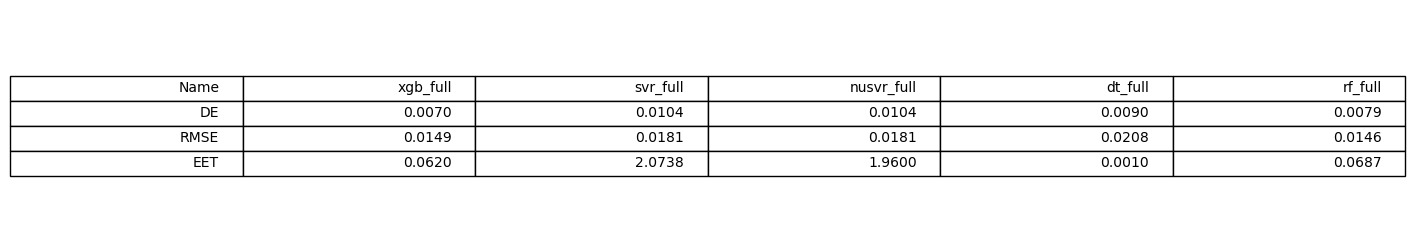

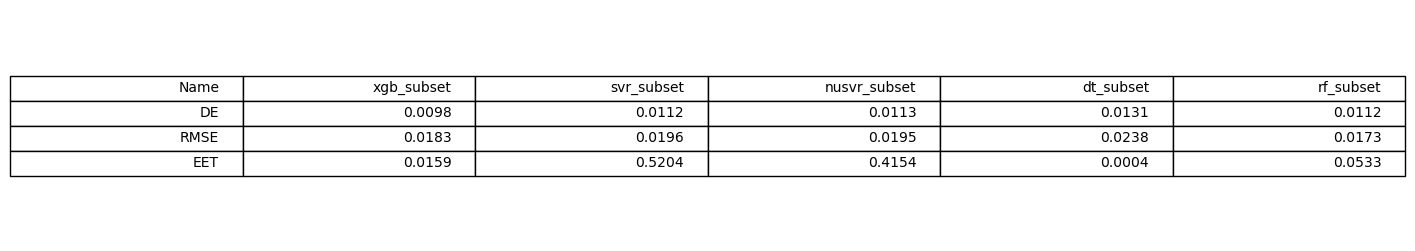

In [26]:
full_res = [["Name", "DE", "RMSE", "EET"]]
sub_res = [["Name", "DE", "RMSE", "EET"]]
# DE - displacement error (m)
# RMSE - root mean square error (m)
# EET - epoch elapsed time (s)

def f(x):
    return "{:.4f}".format(x)

for case in results.keys():
    if case.endswith('full'):
        full_res.append([
            case,
            f(results[case]['displacement']),
            f(results[case]['rmse']),
            f(measure_speed(results[case]['estimator'], full_data[:1200]))
        ])
    else:
        sub_res.append([
            case,
            f(results[case]['displacement']),
            f(results[case]['rmse']),
            f(measure_speed(results[case]['estimator'], subset_data[:1200]))
        ])

def make_table(data):
    plt.figure(figsize=(18, 3)) 
    table = plt.table(cellText=np.array(data).T, loc='center')

    # Formatting the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Adjust font size as needed
    table.scale(1, 1.5)  # Adjust table scale as needed

make_table(full_res)
plt.axis('off')
make_table(sub_res)
plt.axis('off')
# Removing axis
plt.show()

In [179]:
i = 0
SUBJECTS = ['sub-V1005']
evoked = mne.read_evokeds(f"{BASE_WORKDIR}/{SUBJECTS[0]}/evoked-full-ave.fif")[0]
features = norm(evoked.data.T)
#features = norm(to_features_array(evoked))
predicted_dipoles = results['dt_full']['estimator'].predict(features)
dipoles = mne.read_dipole(f'{BASE_WORKDIR}/{SUBJECTS[0]}/full-dipoles.dip')
dipoles_copy = dipoles.copy()
dipoles_copy.pos = predicted_dipoles
displacement_error(dipoles.pos, dipoles_copy.pos)

Reading /home/s8/Documents/VU/dataset/workdir/sub-V1005/evoked-full-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms (0.33 × rc_plus_sentence_target + 0.22 × rc_plus_word_target + 0.22 × rc_minus_sentence_target + 0.22 × rc_minus_word_target)
        0 CTF compensation matrices available
        nave = 270 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
1441 dipole(s) found


0.05341982714501823

In [176]:
dipoles.pos = results['dt_full']['y_test']#[300:320]
dipoles_copy.pos = results['dt_full']['predictions']#[300:320]
displacement_error(dipoles.pos, dipoles_copy.pos)
# the fact is that with y test I get more or less okay'ish results.
# if I re-load same data from file I get 5 cm displacement
# which is odd because data I reload is same used to train test split x_test

0.0077258781053037035

In [177]:
# Display contrast between MNE calculated and model predicted dipole locations
from const import SUBJECTS_DIR
SUBJECT_ID = SUBJECTS[0]
TRANS_PATH = f"{SUBJECTS_DIR}/{SUBJECT_ID}/bem/{SUBJECT_ID}-trans.fif"
white = (1.0, 1.0, 1.0)  # RGB values for a white color
mne.viz.set_3d_backend('pyvistaqt')
fig = mne.viz.create_3d_figure(size=(600, 400), bgcolor=white)
coord_frame = "head"

# Plot the cortex
fig = mne.viz.plot_alignment(
    subject=SUBJECT_ID,
    subjects_dir=SUBJECTS_DIR,
    trans=TRANS_PATH,
    surfaces=dict(white=0.2, head=0.1),
    coord_frame=coord_frame,
    fig=fig
)

# Mark the position of the dipoles with small blue dots
mne.viz.plot_dipole_locations(
    dipoles=dipoles,
    trans=TRANS_PATH,
    mode="sphere",
    subject=SUBJECT_ID,
    subjects_dir=SUBJECTS_DIR,
    coord_frame=coord_frame,
    scale=12e-4,
    color='blue',
    fig=fig,
)

# Mark the position of predicted dipoles with small red dots
mne.viz.plot_dipole_locations(
    dipoles=dipoles_copy,
    trans=TRANS_PATH,
    mode="sphere",
    subject=SUBJECT_ID,
    subjects_dir=SUBJECTS_DIR,
    coord_frame=coord_frame,
    scale=12e-4,
    color='red',
    fig=fig,
)

plt.show()

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Using outer_skin.surf for head surface.
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
